# Attention Visualization on MNIST Dataset

In this notebook, we will see the pool4 attention map results from TDMPNet (**vgg_attn_prototype**) with 8 prototypes per class. We will use the following datasets for visualization: 1).**mnist_test_occ_black_1**, 2).**mnist_test_occ_white_2**, 3).**mnist_test_occ_gauss_3**, and 4).**mnist_test_occ_natural_1**.

## Content
* [Black Noise Occlusion (mnist_test_occ_black_1](#1)
* [White Noise Occlusion (mnist_test_occ_white_2](#2)
* [Gaussian Noise Occlusion (mnist_test_occ_gaussian_3](#3)
* [Natural Object Occlusion (mnist_test_occ_natural_1](#4)
* [Conclusion](#5)

In [1]:
import os
os.chdir("..") # change working directory into parent

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from torchvision import transforms

from config.config_parser import get_default_cfg, merge_cfg_from_file, \
    get_dataloader_from_cfg, get_model_from_cfg

<a name='1'></a>
## Black Noise Occlusion (mnist_test_occ_black_1)

First, we will see the result on level-1 black noise occlusion.

In [2]:
# setup parameters, change according your needs
config_file = "pretrained_weight/VGG_Attn_512_pool4_Prototype_8_MNIST/config.yaml"
weight = "pretrained_weight/VGG_Attn_512_pool4_Prototype_8_MNIST/best.pt"
thresh_u = 0.1
thresh_l = 0.8
dataset_name = "mnist_test_occ_black_1"
device = "cuda" if torch.cuda.is_available() else "cpu"

# get the configurations
cfg = get_default_cfg()
cfg = merge_cfg_from_file(cfg, config_file)
cfg["DATASETS"]["TRAIN"] = [""] # No need train set
cfg["DATASETS"]["VAL"] = [""] # No need val set
cfg["DATASETS"]["TEST"] = [dataset_name]
cfg["SOLVER"]["BATCH_SIZE"] = 1
cfg["MODEL"]["ATTN"]["PERCENT_U"] = thresh_u
cfg["MODEL"]["ATTN"]["PERCENT_L"] = thresh_l

# get model and dataloader
model, *_ = get_model_from_cfg(cfg)
model.load_state_dict(torch.load(weight))

# freeze model parameters
for p in model.parameters():
    p.requires_grad = False
    
*_, data_loaders = get_dataloader_from_cfg(cfg)
data_loader_iter = iter(data_loaders[0])

### Helper Function

Below functions are used to get the **attention map on pool4** stage of TDMPNet.

In [3]:
def predict(model, tensor_img, device = "cpu"):
    model.to(device)
    model.eval()
    tensor_img = tensor_img.to(device)
    
    with torch.no_grad():
        score, additional_loss, additional_output = model(tensor_img)
    
        score_prob = F.softmax(score["score"], dim = 1)
        prediction = torch.max(score_prob, dim = 1).indices.to("cpu")
        
        attn_pool4 = additional_output["attn_pool4"]
    
    return prediction, attn_pool4


def to_pil(tensor_image):
    transform = transforms.Compose([transforms.ToPILImage()])
    
    return transform(torch.squeeze(tensor_image))

### One Image Visualization

Now we will visualize the attention map per one image example. Run below cell multiple times to see more attention maps.

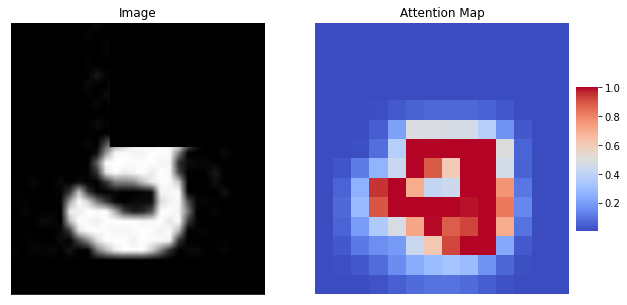

Prediction: 5
Ground truth: 3


In [4]:
# run multiple times
tensor_img, label = next(data_loader_iter)
img = to_pil(tensor_img)

prediction, attn_pool4 = predict(model, tensor_img, device = device)
attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()

# visualize the result
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax = ax.flat

ax[0].imshow(img, aspect = "auto")
ax[0].set_title(f"Image")

sns.heatmap(attn_pool4, cmap = "coolwarm", cbar = True, cbar_ax = cbar_ax, ax = ax[1])
ax[1].set_title(f"Attention Map")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()

print(f"Prediction: {prediction.item()}")
print(f"Ground truth: {label.item()}")

From above visualization, we can see that the occluded parts (black region) are represented as blue color in the attention map. It means that the occluded parts of the image are filtered out successfully with TDMPNet. If we run the cell multiple times, we also see that some of the predictions are wrong. However, some mispredictions are hard even for human eyes to classify them.

### Good Predictions

Now we will visualize some of images along with the attention map that lead to correct predictions.

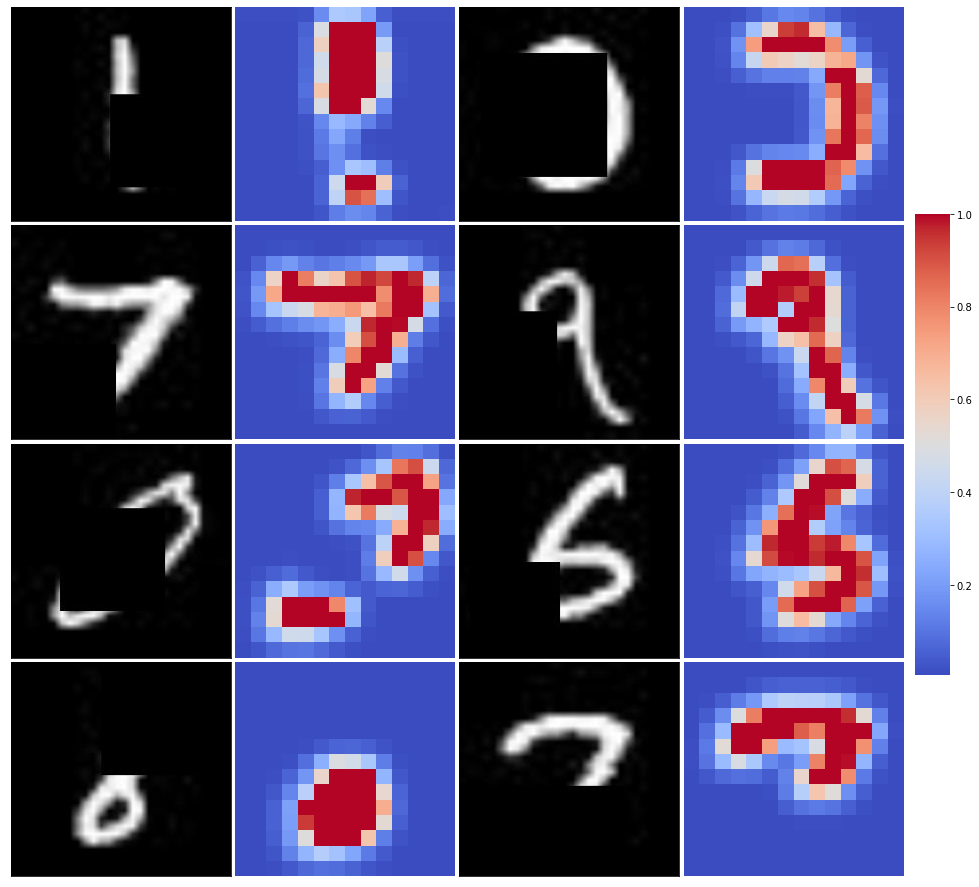

In [5]:
# good predictions
data_loader_iter = iter(data_loaders[0])
good_preds = []

while len(good_preds) < 8:
    tensor_img, label = next(data_loader_iter)
    img = to_pil(tensor_img)

    prediction, attn_pool4 = predict(model, tensor_img, device = device)
    attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()
    
    if prediction.item() == label.item():
        good_preds.append([img, attn_pool4])
    
# visualization
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 2):
    ax[i].imshow(good_preds[i//2][0], aspect = "auto")
    sns.heatmap(good_preds[i//2][1], cmap = "coolwarm", 
                cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax,
                ax = ax[i+1])
    
for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.02, hspace = 0.02)
plt.show()

# save the image
save_dir = "visualization"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "mnist_occ_black_1_good.jpg"))

### Bad Predictions

Now we will visualize some of the wrong predictions.

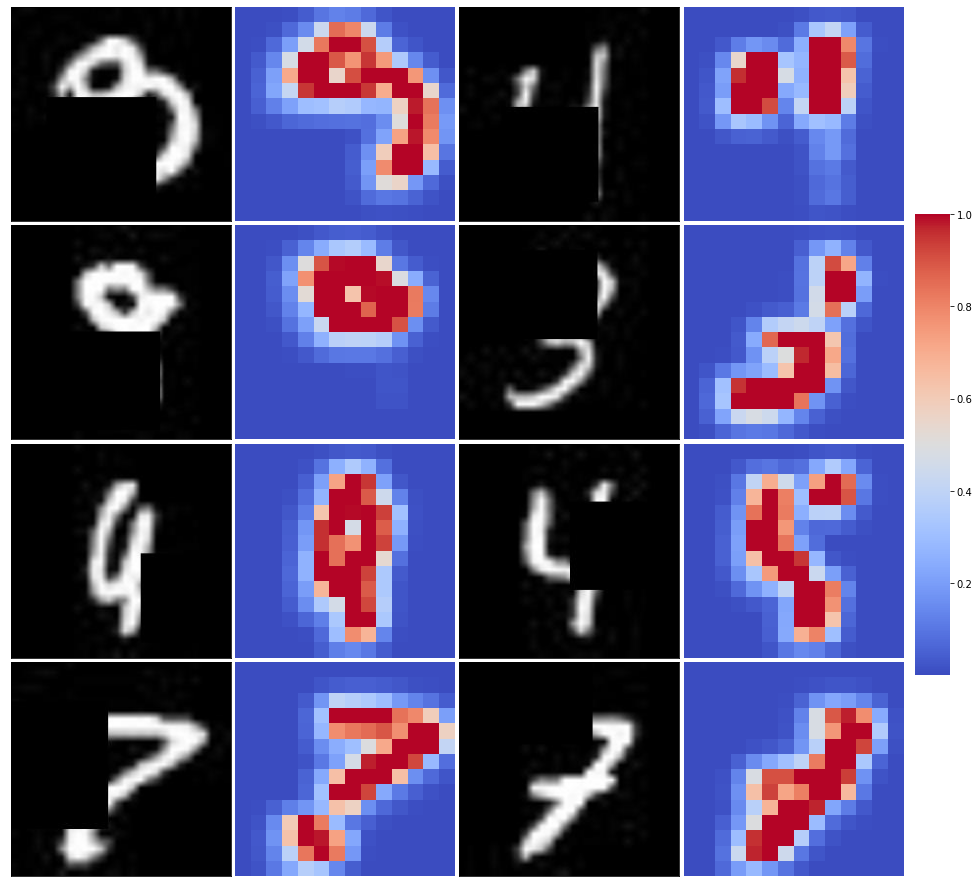

In [6]:
# bad predictions
data_loader_iter = iter(data_loaders[0])
bad_preds = []

while len(bad_preds) < 8:
    tensor_img, label = next(data_loader_iter)
    img = to_pil(tensor_img)

    prediction, attn_pool4 = predict(model, tensor_img, device = device)
    attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()
    
    if prediction.item() != label.item():
        bad_preds.append([img, attn_pool4])
    
# visualization
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 2):
    ax[i].imshow(bad_preds[i//2][0], aspect = "auto")
    sns.heatmap(bad_preds[i//2][1], cmap = "coolwarm", 
                cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax,
                ax = ax[i+1])
    
for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.02, hspace = 0.02)
plt.show()

# save the image
save_dir = "visualization"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "mnist_occ_black_1_bad.jpg"))

<a name='2'></a>
## White Noise Occlusion (mnist_test_occ_white_2)

Next, we will see the result on level-2 white noise occlusion.

In [7]:
# setup parameters, change according your needs
config_file = "pretrained_weight/VGG_Attn_512_pool4_Prototype_8_MNIST/config.yaml"
weight = "pretrained_weight/VGG_Attn_512_pool4_Prototype_8_MNIST/best.pt"
thresh_u = 0.1
thresh_l = 0.8
dataset_name = "mnist_test_occ_white_2"
device = "cuda" if torch.cuda.is_available() else "cpu"

# get the configurations
cfg = get_default_cfg()
cfg = merge_cfg_from_file(cfg, config_file)
cfg["DATASETS"]["TRAIN"] = [""] # No need train set
cfg["DATASETS"]["VAL"] = [""] # No need val set
cfg["DATASETS"]["TEST"] = [dataset_name]
cfg["SOLVER"]["BATCH_SIZE"] = 1
cfg["MODEL"]["ATTN"]["PERCENT_U"] = thresh_u
cfg["MODEL"]["ATTN"]["PERCENT_L"] = thresh_l

# get model and dataloader
model, *_ = get_model_from_cfg(cfg)
model.load_state_dict(torch.load(weight))

# freeze model parameters
for p in model.parameters():
    p.requires_grad = False
    
*_, data_loaders = get_dataloader_from_cfg(cfg)
data_loader_iter = iter(data_loaders[0])

### Helper Function

Below functions are used to get the **attention map on pool4** stage of TDMPNet.

In [8]:
def predict(model, tensor_img, device = "cpu"):
    model.to(device)
    model.eval()
    tensor_img = tensor_img.to(device)
    
    with torch.no_grad():
        score, additional_loss, additional_output = model(tensor_img)
    
        score_prob = F.softmax(score["score"], dim = 1)
        prediction = torch.max(score_prob, dim = 1).indices.to("cpu")
        
        attn_pool4 = additional_output["attn_pool4"]
    
    return prediction, attn_pool4


def to_pil(tensor_image):
    transform = transforms.Compose([transforms.ToPILImage()])
    
    return transform(torch.squeeze(tensor_image))

### One Image Visualization

Now we will visualize the attention map per one image example. Run below cell multiple times to see more attention maps.

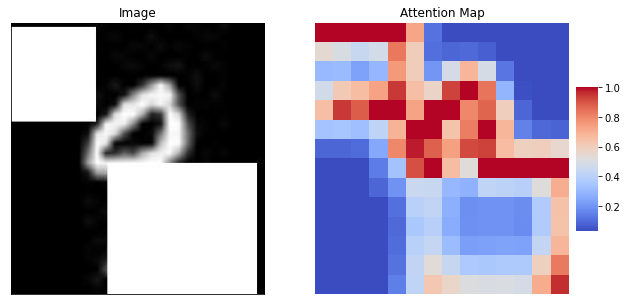

Prediction: 2
Ground truth: 9


In [9]:
# run multiple times
tensor_img, label = next(data_loader_iter)
img = to_pil(tensor_img)

prediction, attn_pool4 = predict(model, tensor_img, device = device)
attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()

# visualize the result
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax = ax.flat

ax[0].imshow(img, aspect = "auto")
ax[0].set_title(f"Image")

sns.heatmap(attn_pool4, cmap = "coolwarm", cbar = True, cbar_ax = cbar_ax, ax = ax[1])
ax[1].set_title(f"Attention Map")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()

print(f"Prediction: {prediction.item()}")
print(f"Ground truth: {label.item()}")

From above figure, we can see that white noise will mess up the attention map. This means that the model actually recognize white color as an important feature for predictions. In order to handle the bias, we should train the model using various colors and this can be done by using color data augmentation, such as **ColorJitter**.

### Good Predictions

Now we will visualize some of images along with the attention map that lead to correct predictions.

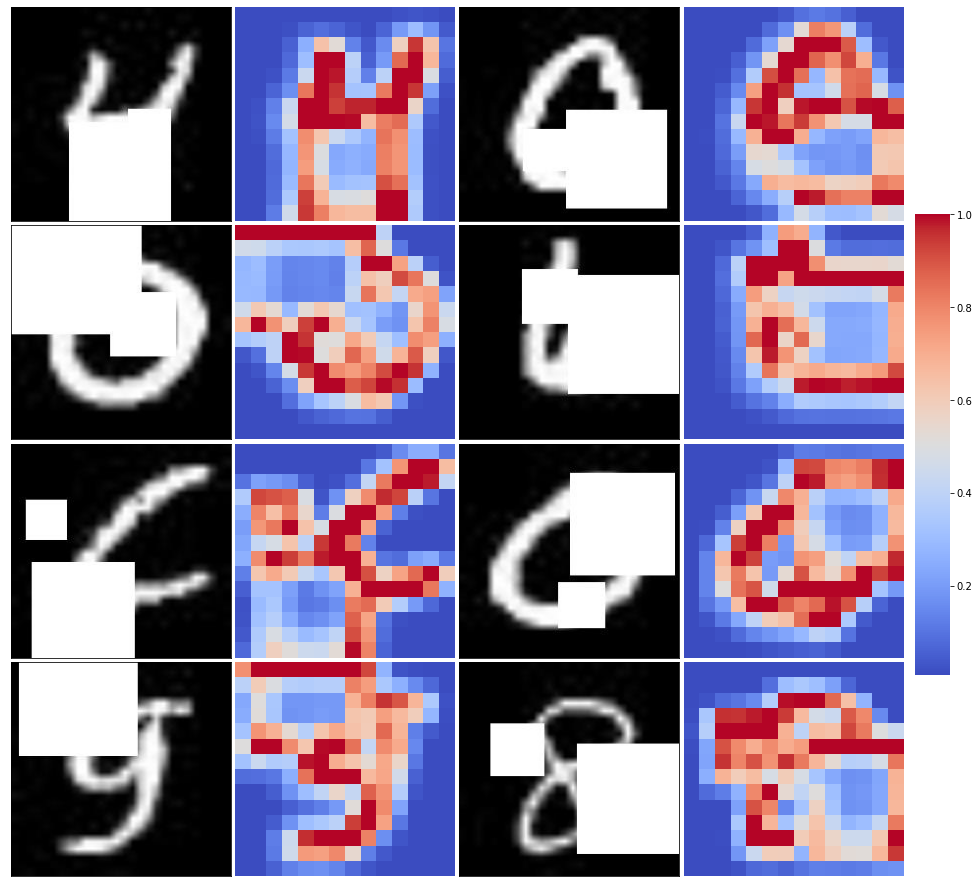

In [10]:
# good predictions
data_loader_iter = iter(data_loaders[0])
good_preds = []

while len(good_preds) < 8:
    tensor_img, label = next(data_loader_iter)
    img = to_pil(tensor_img)

    prediction, attn_pool4 = predict(model, tensor_img, device = device)
    attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()
    
    if prediction.item() == label.item():
        good_preds.append([img, attn_pool4])
    
# visualization
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 2):
    ax[i].imshow(good_preds[i//2][0], aspect = "auto")
    sns.heatmap(good_preds[i//2][1], cmap = "coolwarm", 
                cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax,
                ax = ax[i+1])
    
for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.02, hspace = 0.02)
plt.show()

# save the image
save_dir = "visualization"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "mnist_occ_white_2_good.jpg"))

### Bad Predictions

Now we will visualize some of the wrong predictions.

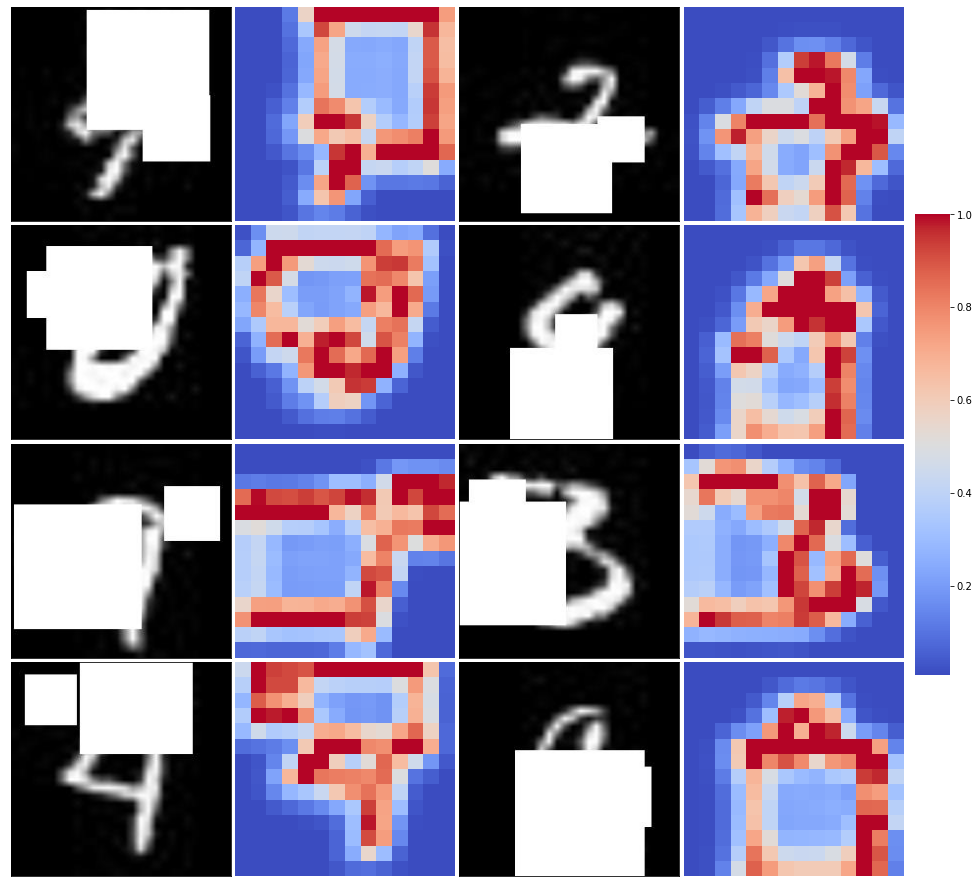

In [11]:
# bad predictions
data_loader_iter = iter(data_loaders[0])
bad_preds = []

while len(bad_preds) < 8:
    tensor_img, label = next(data_loader_iter)
    img = to_pil(tensor_img)

    prediction, attn_pool4 = predict(model, tensor_img, device = device)
    attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()
    
    if prediction.item() != label.item():
        bad_preds.append([img, attn_pool4])
    
# visualization
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 2):
    ax[i].imshow(bad_preds[i//2][0], aspect = "auto")
    sns.heatmap(bad_preds[i//2][1], cmap = "coolwarm", 
                cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax,
                ax = ax[i+1])
    
for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.02, hspace = 0.02)
plt.show()

# save the image
save_dir = "visualization"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "mnist_occ_white_2_bad.jpg"))

<a name='3'></a>
## Gaussian Noise Occlusion (mnist_test_occ_gauss_3)

Next, we will see the result on level-3 gaussian noise occlusion.

In [12]:
# setup parameters, change according your needs
config_file = "pretrained_weight/VGG_Attn_512_pool4_Prototype_8_MNIST/config.yaml"
weight = "pretrained_weight/VGG_Attn_512_pool4_Prototype_8_MNIST/best.pt"
thresh_u = 0.1
thresh_l = 0.8
dataset_name = "mnist_test_occ_gauss_3"
device = "cuda" if torch.cuda.is_available() else "cpu"

# get the configurations
cfg = get_default_cfg()
cfg = merge_cfg_from_file(cfg, config_file)
cfg["DATASETS"]["TRAIN"] = [""] # No need train set
cfg["DATASETS"]["VAL"] = [""] # No need val set
cfg["DATASETS"]["TEST"] = [dataset_name]
cfg["SOLVER"]["BATCH_SIZE"] = 1
cfg["MODEL"]["ATTN"]["PERCENT_U"] = thresh_u
cfg["MODEL"]["ATTN"]["PERCENT_L"] = thresh_l

# get model and dataloader
model, *_ = get_model_from_cfg(cfg)
model.load_state_dict(torch.load(weight))

# freeze model parameters
for p in model.parameters():
    p.requires_grad = False
    
*_, data_loaders = get_dataloader_from_cfg(cfg)
data_loader_iter = iter(data_loaders[0])

### Helper Function

In [13]:
def predict(model, tensor_img, device = "cpu"):
    model.to(device)
    model.eval()
    tensor_img = tensor_img.to(device)
    
    with torch.no_grad():
        score, additional_loss, additional_output = model(tensor_img)
    
        score_prob = F.softmax(score["score"], dim = 1)
        prediction = torch.max(score_prob, dim = 1).indices.to("cpu")
        
        attn_pool4 = additional_output["attn_pool4"]
    
    return prediction, attn_pool4


def to_pil(tensor_image):
    transform = transforms.Compose([transforms.ToPILImage()])
    
    return transform(torch.squeeze(tensor_image))

### One Image Visualization

Now we will visualize the attention map per one image example. Run below cell multiple times to see more attention maps.

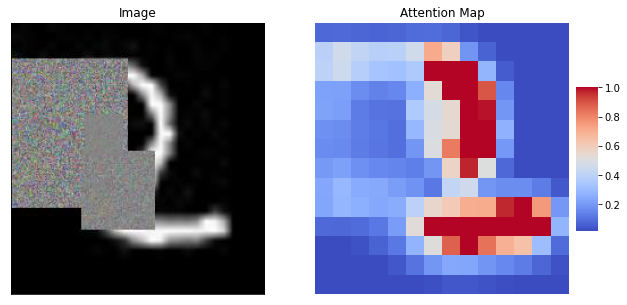

Prediction: 2
Ground truth: 2


In [14]:
# run multiple times
tensor_img, label = next(data_loader_iter)
img = to_pil(tensor_img)

prediction, attn_pool4 = predict(model, tensor_img, device = device)
attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()

# visualize the result
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax = ax.flat

ax[0].imshow(img, aspect = "auto")
ax[0].set_title(f"Image")

sns.heatmap(attn_pool4, cmap = "coolwarm", cbar = True, cbar_ax = cbar_ax, ax = ax[1])
ax[1].set_title(f"Attention Map")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()

print(f"Prediction: {prediction.item()}")
print(f"Ground truth: {label.item()}")

From above visualization, we can see that the occluded parts (noise region) are represented as light blue color in the attention map. Although most of the occluded parts are filtered out, we can still see some high value noises in the attention map (represented as **creme** and **red** color). Similar as white noise occlusion, one potential way to improve the results is by applying data augmentation to get various image colors. This is becau\se original MNIST dataset only use black and white color images.

### Good Predictions

Now we will visualize some of images along with the attention map that lead to correct predictions.

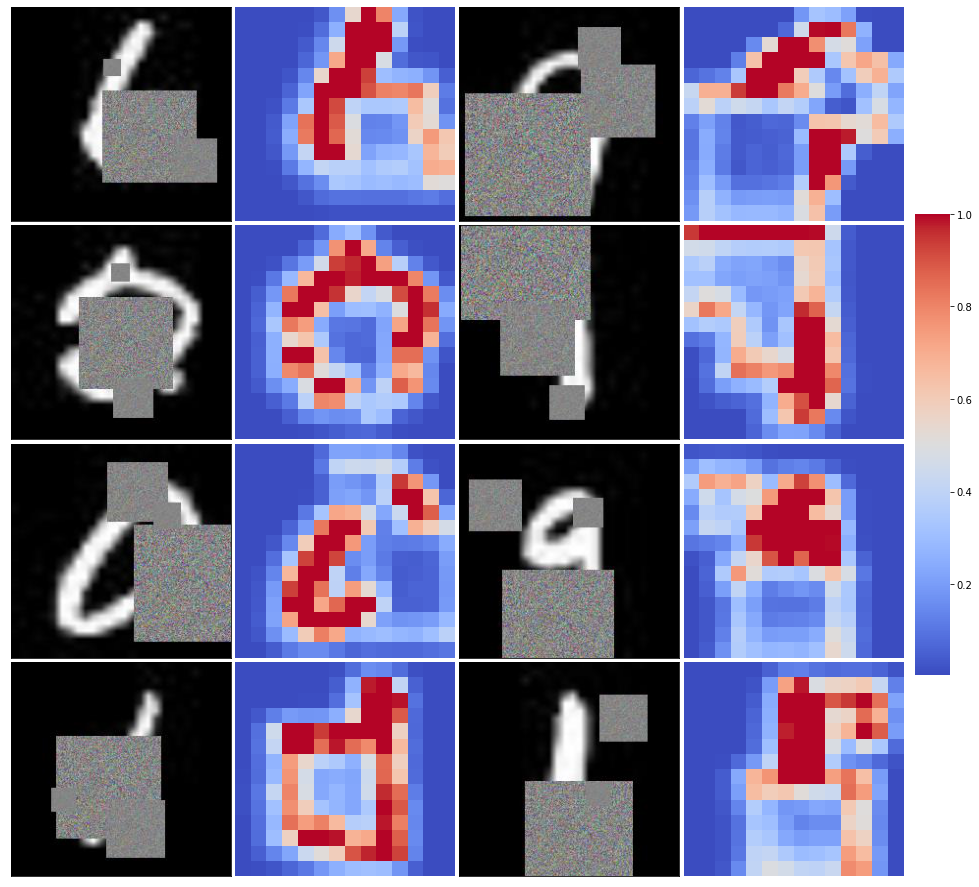

In [15]:
# good predictions
data_loader_iter = iter(data_loaders[0])
good_preds = []

while len(good_preds) < 8:
    tensor_img, label = next(data_loader_iter)
    img = to_pil(tensor_img)

    prediction, attn_pool4 = predict(model, tensor_img, device = device)
    attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()
    
    if prediction.item() == label.item():
        good_preds.append([img, attn_pool4])
    
# visualization
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 2):
    ax[i].imshow(good_preds[i//2][0], aspect = "auto")
    sns.heatmap(good_preds[i//2][1], cmap = "coolwarm", 
                cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax,
                ax = ax[i+1])
    
for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.02, hspace = 0.02)
plt.show()

# save the image
save_dir = "visualization"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "mnist_occ_gauss_3_good.jpg"))

### Bad Predictions

Now we will visualize some of the wrong predictions.

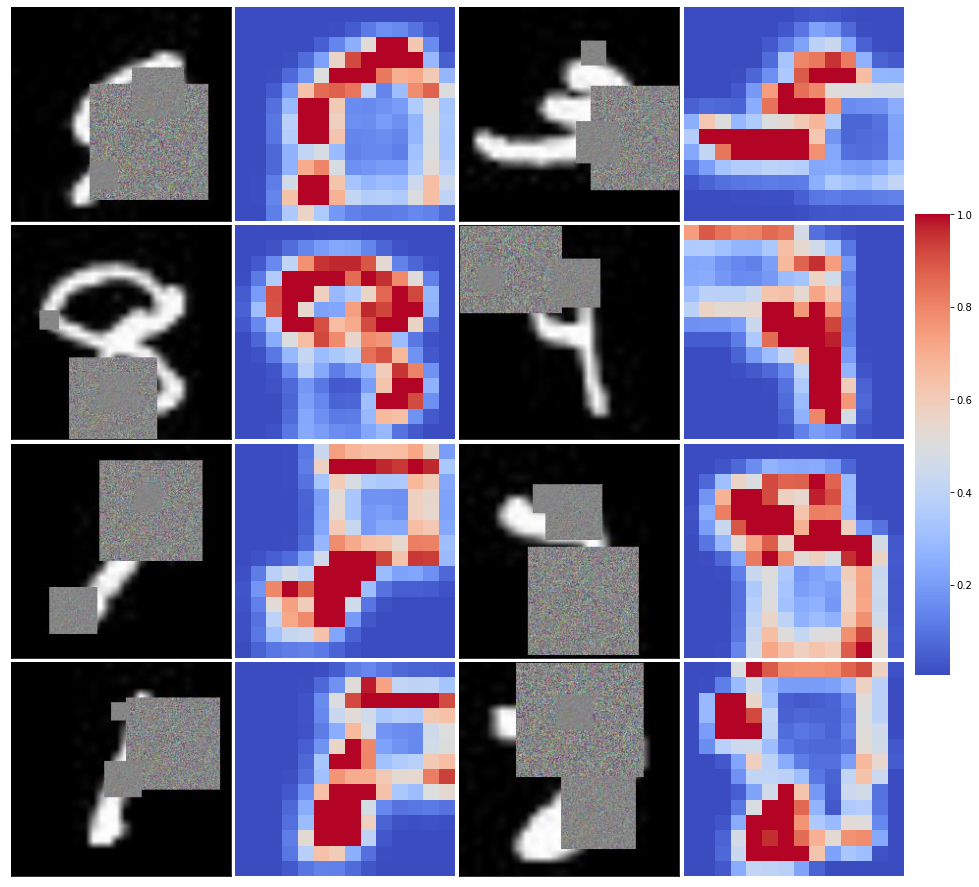

In [16]:
# bad predictions
data_loader_iter = iter(data_loaders[0])
bad_preds = []

while len(bad_preds) < 8:
    tensor_img, label = next(data_loader_iter)
    img = to_pil(tensor_img)

    prediction, attn_pool4 = predict(model, tensor_img, device = device)
    attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()
    
    if prediction.item() != label.item():
        bad_preds.append([img, attn_pool4])
    
# visualization
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 2):
    ax[i].imshow(bad_preds[i//2][0], aspect = "auto")
    sns.heatmap(bad_preds[i//2][1], cmap = "coolwarm", 
                cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax,
                ax = ax[i+1])
    
for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.02, hspace = 0.02)
plt.show()

# save the image
save_dir = "visualization"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "mnist_occ_gauss_3_bad.jpg"))

<a name='4'></a>
## Natural Object Occlusion (mnist_test_occ_natural_1)

Lastly, we will see the result on level-1 natural image occlusion.

In [17]:
# setup parameters, change according your needs
config_file = "pretrained_weight/VGG_Attn_512_pool4_Prototype_8_MNIST/config.yaml"
weight = "pretrained_weight/VGG_Attn_512_pool4_Prototype_8_MNIST/best.pt"
thresh_u = 0.1
thresh_l = 0.8
dataset_name = "mnist_test_occ_natural_1"
device = "cuda" if torch.cuda.is_available() else "cpu"

# get the configurations
cfg = get_default_cfg()
cfg = merge_cfg_from_file(cfg, config_file)
cfg["DATASETS"]["TRAIN"] = [""] # No need train set
cfg["DATASETS"]["VAL"] = [""] # No need val set
cfg["DATASETS"]["TEST"] = [dataset_name]
cfg["SOLVER"]["BATCH_SIZE"] = 1
cfg["MODEL"]["ATTN"]["PERCENT_U"] = thresh_u
cfg["MODEL"]["ATTN"]["PERCENT_L"] = thresh_l

# get model and dataloader
model, *_ = get_model_from_cfg(cfg)
model.load_state_dict(torch.load(weight))

# freeze model parameters
for p in model.parameters():
    p.requires_grad = False
    
*_, data_loaders = get_dataloader_from_cfg(cfg)
data_loader_iter = iter(data_loaders[0])

### Helper Function

In [18]:
def predict(model, tensor_img, device = "cpu"):
    model.to(device)
    model.eval()
    tensor_img = tensor_img.to(device)
    
    with torch.no_grad():
        score, additional_loss, additional_output = model(tensor_img)
    
        score_prob = F.softmax(score["score"], dim = 1)
        prediction = torch.max(score_prob, dim = 1).indices.to("cpu")
        
        attn_pool4 = additional_output["attn_pool4"]
    
    return prediction, attn_pool4


def to_pil(tensor_image):
    transform = transforms.Compose([transforms.ToPILImage()])
    
    return transform(torch.squeeze(tensor_image))

### One Image Visualization

Now we will visualize the attention map per one image example. Run below cell multiple times to see more attention maps.

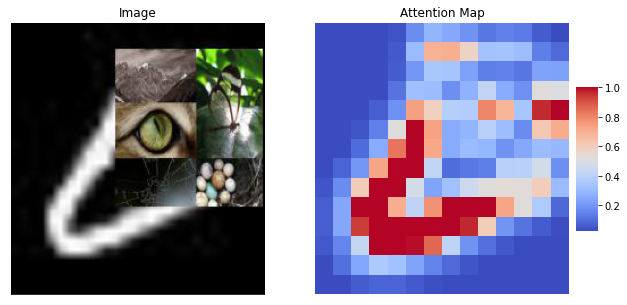

Prediction: 0
Ground truth: 0


In [19]:
# run multiple times
tensor_img, label = next(data_loader_iter)
img = to_pil(tensor_img)

prediction, attn_pool4 = predict(model, tensor_img, device = device)
attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()

# visualize the result
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
cbar_ax = fig.add_axes([.91, .3, .03, .4])
ax = ax.flat

ax[0].imshow(img, aspect = "auto")
ax[0].set_title(f"Image")

sns.heatmap(attn_pool4, cmap = "coolwarm", cbar = True, cbar_ax = cbar_ax, ax = ax[1])
ax[1].set_title(f"Attention Map")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

plt.show()

print(f"Prediction: {prediction.item()}")
print(f"Ground truth: {label.item()}")

From above observation, we can see that the filtered attention map results are not as good as gaussian random noise. This can be seen from high similarities (denoted as **red** and **creme** color) on some parts of occluder. Further experiments is needed for this dataset, however it is better to use color data augmentation first and see whether the results are better or not.

### Good Predictions

Now we will visualize some of images along with the attention map that lead to correct predictions.

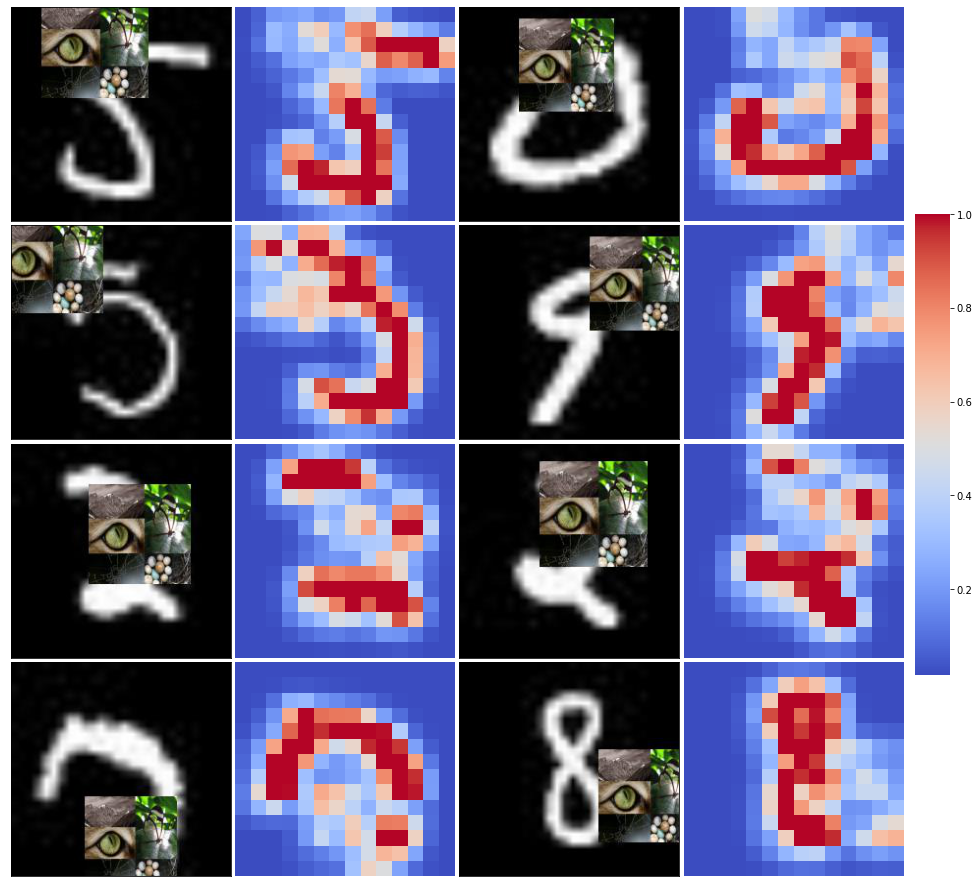

In [20]:
# good predictions
data_loader_iter = iter(data_loaders[0])
good_preds = []

while len(good_preds) < 8:
    tensor_img, label = next(data_loader_iter)
    img = to_pil(tensor_img)

    prediction, attn_pool4 = predict(model, tensor_img, device = device)
    attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()
    
    if prediction.item() == label.item():
        good_preds.append([img, attn_pool4])
    
# visualization
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 2):
    ax[i].imshow(good_preds[i//2][0], aspect = "auto")
    sns.heatmap(good_preds[i//2][1], cmap = "coolwarm", 
                cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax,
                ax = ax[i+1])
    
for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.02, hspace = 0.02)
plt.show()

# save the image
save_dir = "visualization"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "mnist_occ_natural_1_good.jpg"))

### Bad Predictions

Now we will visualize some of the wrong predictions.

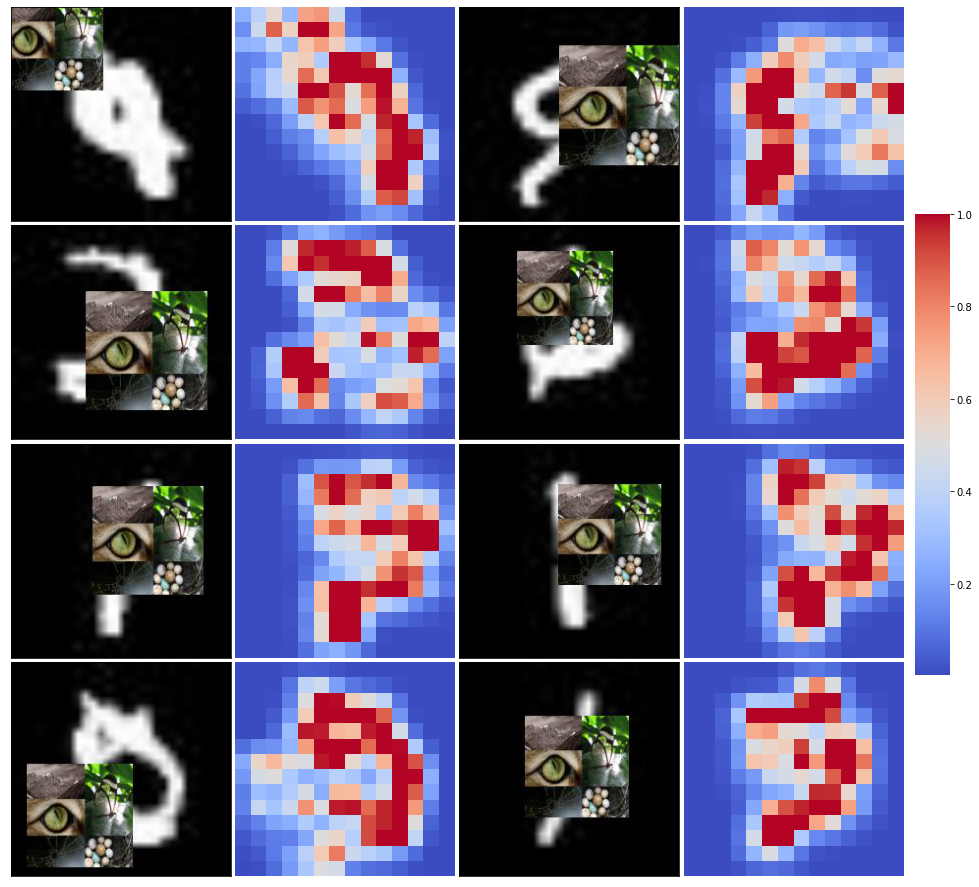

In [21]:
# bad predictions
data_loader_iter = iter(data_loaders[0])
bad_preds = []

while len(bad_preds) < 8:
    tensor_img, label = next(data_loader_iter)
    img = to_pil(tensor_img)

    prediction, attn_pool4 = predict(model, tensor_img, device = device)
    attn_pool4 = torch.squeeze(attn_pool4).to("cpu").numpy()
    
    if prediction.item() != label.item():
        bad_preds.append([img, attn_pool4])
    
# visualization
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 2):
    ax[i].imshow(bad_preds[i//2][0], aspect = "auto")
    sns.heatmap(bad_preds[i//2][1], cmap = "coolwarm", 
                cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax,
                ax = ax[i+1])
    
for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.02, hspace = 0.02)
plt.show()

# save the image
save_dir = "visualization"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "mnist_occ_natural_1_bad.jpg"))

<a name='5'></a>
## Conclusion

In **mnist_occ_black_1** dataset we can see that the model works fine. However, the others dataset especially **mnist_occ_white_2**, we observed that the attention map is not good enough. The main reason is that the model recognize white color as important feature for predictions. Therefore, we should try to use color data augmentation, such as **ColorJitter** in order to create various colors of MNIST training set.